In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collect_data import *
from tqdm import tqdm

In [2]:
for img, _ in train_loader:
    print(img.shape) 
    break 

torch.Size([64, 3, 150, 150])


In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=75):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.conv_layer1(x)))
        x = self.max_pool(F.relu(self.conv_layer2(x)))
        x = self.max_pool(F.relu(self.conv_layer3(x)))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.conv_layer1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer3(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model = CNN(num_classes=75).to(device)
print(model)

CNN(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20736, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=75, bias=True)
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
def train(model, num_epochs, loss_fn=loss_fn, train_loader=train_loader, optimizer=optimizer, device=device):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        correct_train = 0
        total_train = 0
        
        for batch in tqdm(train_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_train += labels.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            
        acc_train = 100 * correct_train / total_train
        train_acc.append(acc_train)
        avg_train_loss = total_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        
        model.eval()
        loss_val = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader):
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)

                loss_val += loss.item()
                total_val += labels.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
                
        acc_val = 100 * correct_val / total_val
        val_acc.append(acc_val)
        avg_val_loss = total_loss / len(val_loader)
        val_loss.append(avg_val_loss)
        
        print(f"Epoch ({epoch+1}/{num_epochs}) train accuracy: {acc_train}, val accuracy: {acc_val}, train loss: {avg_train_loss}, val loss: {avg_val_loss}")
        
    return train_loss, val_loss, train_acc, val_acc

In [8]:
def plot_training_curve(train_acc, val_acc, train_loss, val_loss):
    threshold = 95
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (95%)')
    
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title("Training & Validation Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 21/21 [00:14<00:00,  1.43it/s]


Epoch (1/30) train accuracy: 10.059626851317562, val accuracy: 15.76923076923077, train loss: 3.752665141733681, val loss: 14.653263886769613


100%|██████████| 21/21 [00:14<00:00,  1.43it/s]


Epoch (2/30) train accuracy: 27.79380650125024, val accuracy: 34.69230769230769, train loss: 2.720767625948278, val loss: 10.623949777512323


100%|██████████| 21/21 [00:15<00:00,  1.39it/s]


Epoch (3/30) train accuracy: 39.73841123292941, val accuracy: 44.0, train loss: 2.1589299905590895, val loss: 8.430107582183112


100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


Epoch (4/30) train accuracy: 47.989998076553185, val accuracy: 48.07692307692308, train loss: 1.8313940996077003, val loss: 7.151157912753877


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


Epoch (5/30) train accuracy: 53.35641469513368, val accuracy: 52.15384615384615, train loss: 1.63110206476072, val loss: 6.3690652052561445


100%|██████████| 21/21 [00:14<00:00,  1.45it/s]


Epoch (6/30) train accuracy: 57.66493556453164, val accuracy: 51.84615384615385, train loss: 1.4866648636213162, val loss: 5.805072324616568


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


Epoch (7/30) train accuracy: 60.28082323523755, val accuracy: 54.15384615384615, train loss: 1.3567915049994863, val loss: 5.297947781426566


100%|██████████| 21/21 [00:14<00:00,  1.44it/s]


Epoch (8/30) train accuracy: 64.10848240046163, val accuracy: 56.15384615384615, train loss: 1.227429581851494, val loss: 4.792820271991548


100%|██████████| 21/21 [00:15<00:00,  1.39it/s]


Epoch (9/30) train accuracy: 66.64743219849971, val accuracy: 55.84615384615385, train loss: 1.1214470521705906, val loss: 4.378983727523258


100%|██████████| 21/21 [00:14<00:00,  1.45it/s]


Epoch (10/30) train accuracy: 69.37872667820734, val accuracy: 57.92307692307692, train loss: 1.0360303913674704, val loss: 4.045452004387265


100%|██████████| 21/21 [00:14<00:00,  1.45it/s]


Epoch (11/30) train accuracy: 71.28293902673592, val accuracy: 58.07692307692308, train loss: 0.9725005299579806, val loss: 3.7973830217406865


100%|██████████| 21/21 [00:14<00:00,  1.43it/s]


Epoch (12/30) train accuracy: 73.49490286593576, val accuracy: 60.15384615384615, train loss: 0.910784248171783, val loss: 3.556395635718391


100%|██████████| 21/21 [00:14<00:00,  1.44it/s]


Epoch (13/30) train accuracy: 75.16830159646086, val accuracy: 60.53846153846154, train loss: 0.8293788625699717, val loss: 3.238526987177985


100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


Epoch (14/30) train accuracy: 75.4952875552991, val accuracy: 60.61538461538461, train loss: 0.8068680828664361, val loss: 3.1506277521451316


100%|██████████| 21/21 [00:15<00:00,  1.37it/s]


Epoch (15/30) train accuracy: 76.6493556453164, val accuracy: 61.30769230769231, train loss: 0.7560961733504039, val loss: 2.9523755340349105


100%|██████████| 21/21 [00:15<00:00,  1.37it/s]


Epoch (16/30) train accuracy: 77.78418926716677, val accuracy: 62.30769230769231, train loss: 0.7076836362844561, val loss: 2.7633361035869237


100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


Epoch (17/30) train accuracy: 79.36141565685709, val accuracy: 59.76923076923077, train loss: 0.6661175078735119, val loss: 2.6010302688394273


100%|██████████| 21/21 [00:15<00:00,  1.39it/s]


Epoch (18/30) train accuracy: 79.95768417003269, val accuracy: 60.69230769230769, train loss: 0.6606015155955058, val loss: 2.5794916323253085


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


Epoch (19/30) train accuracy: 81.68878630505867, val accuracy: 64.07692307692308, train loss: 0.5902849922819835, val loss: 2.3049223508153642


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


Epoch (20/30) train accuracy: 82.1888824773995, val accuracy: 63.46153846153846, train loss: 0.5479162244535074, val loss: 2.139482400247029


100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


Epoch (21/30) train accuracy: 83.1313714175803, val accuracy: 63.0, train loss: 0.5364495915610615, val loss: 2.0947079289527166


100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


Epoch (22/30) train accuracy: 84.11232929409502, val accuracy: 62.69230769230769, train loss: 0.5029798191858501, val loss: 1.9640164368209385


100%|██████████| 21/21 [00:14<00:00,  1.43it/s]


Epoch (23/30) train accuracy: 85.11252163877668, val accuracy: 62.0, train loss: 0.4824178158873465, val loss: 1.883726709655353


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


Epoch (24/30) train accuracy: 85.22792844777842, val accuracy: 63.15384615384615, train loss: 0.46259059866027136, val loss: 1.806306147149631


100%|██████████| 21/21 [00:15<00:00,  1.35it/s]


Epoch (25/30) train accuracy: 86.49740334679746, val accuracy: 63.61538461538461, train loss: 0.4246389351603461, val loss: 1.6581139372927802


100%|██████████| 21/21 [00:15<00:00,  1.35it/s]


Epoch (26/30) train accuracy: 87.01673398730524, val accuracy: 63.38461538461539, train loss: 0.4100805857196087, val loss: 1.6012670490003766


100%|██████████| 21/21 [00:15<00:00,  1.39it/s]


Epoch (27/30) train accuracy: 86.9974995191383, val accuracy: 62.07692307692308, train loss: 0.41274486682037026, val loss: 1.6116704323462077


100%|██████████| 21/21 [00:14<00:00,  1.44it/s]


Epoch (28/30) train accuracy: 87.40142335064435, val accuracy: 64.61538461538461, train loss: 0.3838694090159928, val loss: 1.4989186447291147


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Epoch (29/30) train accuracy: 88.3246778226582, val accuracy: 62.76923076923077, train loss: 0.3526579795814142, val loss: 1.377045444079808


100%|██████████| 21/21 [00:15<00:00,  1.34it/s]


Epoch (30/30) train accuracy: 89.32487016733987, val accuracy: 60.92307692307692, train loss: 0.3367117269918686, val loss: 1.3147791244444393


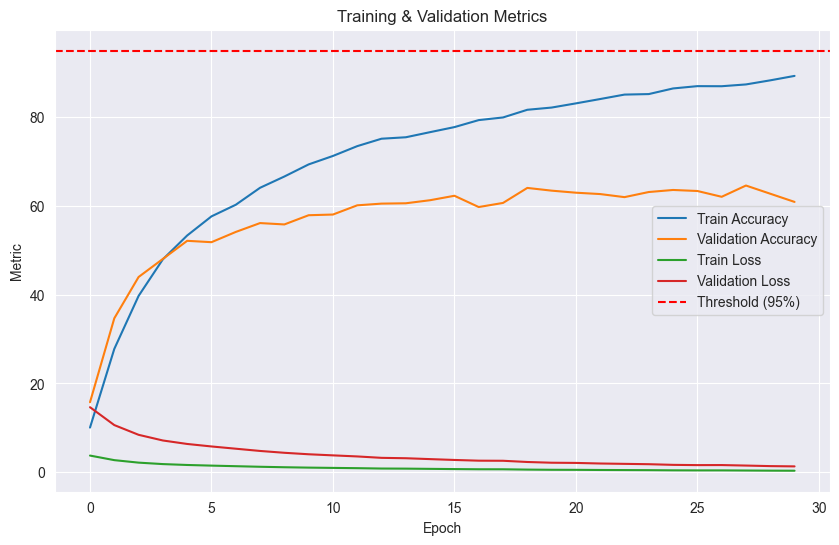

In [9]:
train_loss, val_loss, train_acc, val_acc = train(model, num_epochs=30)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

In [15]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes=75):
        super(CNN_v2, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        
        #out features 256 instead of 128
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.conv_layer1(x)))
        x = self.max_pool(F.relu(self.conv_layer2(x)))
        x = self.max_pool(F.relu(self.conv_layer3(x)))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.conv_layer1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer3(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        
        return x

In [16]:
model_v2 = CNN_v2(75).to(device)
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.001)
print(model_v2)

CNN_v2(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv_layer3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18496, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=75, bias=True)
)


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch (1/30) train accuracy: 10.175033660319292, val accuracy: 19.307692307692307, train loss: 3.5788622949181534, val loss: 13.97460515158517


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch (2/30) train accuracy: 26.67820734756684, val accuracy: 32.76923076923077, train loss: 2.786926188120028, val loss: 10.882283210754395


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch (3/30) train accuracy: 39.93075591459896, val accuracy: 42.69230769230769, train loss: 2.215906833730093, val loss: 8.652588588850838


100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


Epoch (4/30) train accuracy: 49.06712829390268, val accuracy: 47.61538461538461, train loss: 1.8407221858094378, val loss: 7.187581868398757


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Epoch (5/30) train accuracy: 54.048855549144065, val accuracy: 51.23076923076923, train loss: 1.6136627299029653, val loss: 6.3009687548591975


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch (6/30) train accuracy: 58.14579726870552, val accuracy: 54.0, train loss: 1.4297028852672111, val loss: 5.582649361519587


100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


Epoch (7/30) train accuracy: 62.26197345643393, val accuracy: 54.07692307692308, train loss: 1.2860048311512644, val loss: 5.021542674019223


100%|██████████| 21/21 [00:21<00:00,  1.05s/it]


Epoch (8/30) train accuracy: 65.07020580880939, val accuracy: 55.30769230769231, train loss: 1.1667381743105447, val loss: 4.555834775879269


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Epoch (9/30) train accuracy: 68.41700326985959, val accuracy: 59.07692307692308, train loss: 1.065932217894531, val loss: 4.16221151749293


100%|██████████| 21/21 [00:19<00:00,  1.05it/s]


Epoch (10/30) train accuracy: 70.84054625889594, val accuracy: 59.23076923076923, train loss: 0.962373253775806, val loss: 3.757838419505528


100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


Epoch (11/30) train accuracy: 72.99480669359492, val accuracy: 59.0, train loss: 0.8948803718497114, val loss: 3.4942947853179205


100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


Epoch (12/30) train accuracy: 73.99499903827659, val accuracy: 60.61538461538461, train loss: 0.8274010245392962, val loss: 3.230804000582014


100%|██████████| 21/21 [00:22<00:00,  1.06s/it]


Epoch (13/30) train accuracy: 76.80323139065204, val accuracy: 59.23076923076923, train loss: 0.7614013948818532, val loss: 2.9730911609672366


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Epoch (14/30) train accuracy: 77.03404500865551, val accuracy: 61.61538461538461, train loss: 0.7162567929523748, val loss: 2.7968122391473678


100%|██████████| 21/21 [00:22<00:00,  1.06s/it]


Epoch (15/30) train accuracy: 79.6114637430275, val accuracy: 63.07692307692308, train loss: 0.6655893343977812, val loss: 2.5989678771722886


100%|██████████| 21/21 [00:19<00:00,  1.06it/s]


Epoch (16/30) train accuracy: 80.74629736487786, val accuracy: 63.23076923076923, train loss: 0.6102087392312724, val loss: 2.3827198389030637


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Epoch (17/30) train accuracy: 81.66955183689171, val accuracy: 60.69230769230769, train loss: 0.5701974023406099, val loss: 2.22648509485381


100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


Epoch (18/30) train accuracy: 82.97749567224466, val accuracy: 62.23076923076923, train loss: 0.5528171200577806, val loss: 2.15861923070181


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch (19/30) train accuracy: 83.53529524908636, val accuracy: 63.23076923076923, train loss: 0.5043233842021082, val loss: 1.9692627383129937


100%|██████████| 21/21 [00:20<00:00,  1.03it/s]


Epoch (20/30) train accuracy: 84.03539142142719, val accuracy: 63.0, train loss: 0.5044201152717195, val loss: 1.9696404501086189


100%|██████████| 21/21 [00:20<00:00,  1.03it/s]


Epoch (21/30) train accuracy: 85.28563185227928, val accuracy: 61.92307692307692, train loss: 0.46844512133336647, val loss: 1.8291666642540978


100%|██████████| 21/21 [00:20<00:00,  1.03it/s]


Epoch (22/30) train accuracy: 86.70898249663396, val accuracy: 61.92307692307692, train loss: 0.40935959067286515, val loss: 1.5984517350083305


100%|██████████| 21/21 [00:22<00:00,  1.09s/it]


Epoch (23/30) train accuracy: 87.1706097326409, val accuracy: 63.69230769230769, train loss: 0.39958728868059995, val loss: 1.5602932224671047


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Epoch (24/30) train accuracy: 87.49759569147913, val accuracy: 62.84615384615385, train loss: 0.3883799670672998, val loss: 1.5165312999770755


100%|██████████| 21/21 [00:20<00:00,  1.01it/s]


Epoch (25/30) train accuracy: 88.78630505866512, val accuracy: 61.30769230769231, train loss: 0.37010568852831677, val loss: 1.4451745933010465


100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


Epoch (26/30) train accuracy: 87.68994037314869, val accuracy: 62.69230769230769, train loss: 0.3806824268000882, val loss: 1.4864742379812967


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Epoch (27/30) train accuracy: 88.63242931332948, val accuracy: 62.69230769230769, train loss: 0.3577200701323951, val loss: 1.3968117024217332


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Epoch (28/30) train accuracy: 89.69032506251202, val accuracy: 62.23076923076923, train loss: 0.3203493843718273, val loss: 1.2508880723090399


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch (29/30) train accuracy: 90.67128293902674, val accuracy: 63.76923076923077, train loss: 0.28667025022753856, val loss: 1.1193790723170554


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch (30/30) train accuracy: 91.17137911136757, val accuracy: 63.30769230769231, train loss: 0.27870883797181817, val loss: 1.0882916530328137


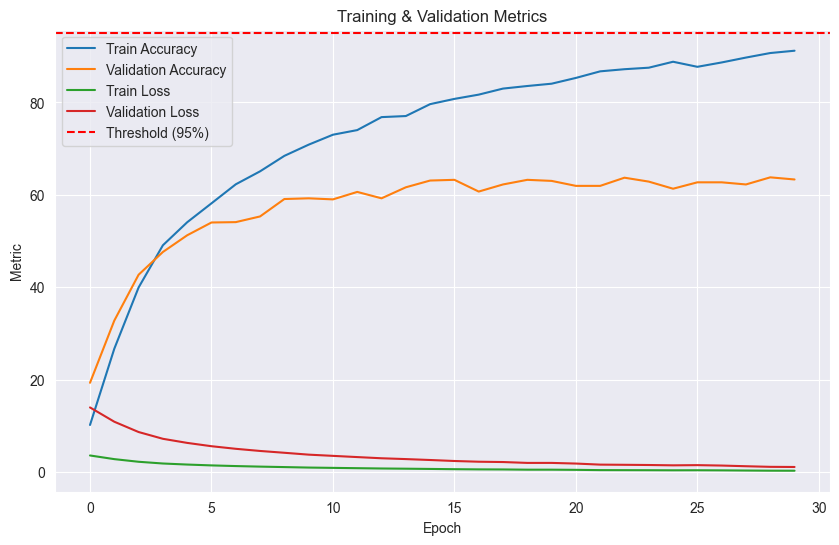

In [17]:
train_loss, val_loss, train_acc, val_acc = train(model_v2, optimizer=optimizer_v2, num_epochs=30)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

In [21]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes=75):
        super(CNN_v3, self).__init__()
        #kernal_size=5 instead of kernal_size=3 
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.conv_layer1(x)))
        x = self.max_pool(F.relu(self.conv_layer2(x)))
        x = self.max_pool(F.relu(self.conv_layer3(x)))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.conv_layer1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer3(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        
        return x

In [22]:
model_v3 = CNN_v3(75).to(device)
optimizer_v3 = optim.Adam(model_v3.parameters(), lr=0.001)

100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Epoch (1/20) train accuracy: 6.212733217926524, val accuracy: 13.076923076923077, train loss: 3.933133669015838, val loss: 15.357950517109462


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch (2/20) train accuracy: 19.40757838045778, val accuracy: 25.923076923076923, train loss: 3.088020432286146, val loss: 12.057984545117332


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch (3/20) train accuracy: 32.333140988651664, val accuracy: 36.23076923076923, train loss: 2.5339964977124843, val loss: 9.894652991067796


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch (4/20) train accuracy: 40.85401038661281, val accuracy: 41.61538461538461, train loss: 2.1497956732424295, val loss: 8.39444024789901


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Epoch (5/20) train accuracy: 47.2975572225428, val accuracy: 47.69230769230769, train loss: 1.8603920282387152, val loss: 7.264387919789269


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch (6/20) train accuracy: 50.182727447586075, val accuracy: 49.23076923076923, train loss: 1.7284248413109198, val loss: 6.7490874755950205


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch (7/20) train accuracy: 55.433737257164836, val accuracy: 52.61538461538461, train loss: 1.5397891213254231, val loss: 6.012509902318318


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch (8/20) train accuracy: 58.0688593960377, val accuracy: 54.30769230769231, train loss: 1.4387163926915425, val loss: 5.617844961938404


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch (9/20) train accuracy: 61.22331217541835, val accuracy: 56.0, train loss: 1.3297381350179998, val loss: 5.192310812927428


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch (10/20) train accuracy: 62.24273898826697, val accuracy: 58.0, train loss: 1.2714676006538113, val loss: 4.964778250172024


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Epoch (11/20) train accuracy: 63.435276014618196, val accuracy: 58.46153846153846, train loss: 1.2256673908815152, val loss: 4.785939335823059


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch (12/20) train accuracy: 66.49355645316408, val accuracy: 58.38461538461539, train loss: 1.1335392020097592, val loss: 4.426200693561917


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch (13/20) train accuracy: 68.0707828428544, val accuracy: 58.15384615384615, train loss: 1.042156200946831, val loss: 4.069371832268579


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch (14/20) train accuracy: 70.76360838622811, val accuracy: 58.23076923076923, train loss: 0.9840837884240035, val loss: 3.8426128881318227


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch (15/20) train accuracy: 70.32121561838815, val accuracy: 58.38461538461539, train loss: 0.9860808645806661, val loss: 3.850410995029268


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch (16/20) train accuracy: 72.3216003077515, val accuracy: 62.23076923076923, train loss: 0.9042764585919496, val loss: 3.530984266882851


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch (17/20) train accuracy: 72.64858626658973, val accuracy: 60.23076923076923, train loss: 0.8871129525870811, val loss: 3.4639648624828885


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch (18/20) train accuracy: 74.68743989228697, val accuracy: 62.61538461538461, train loss: 0.8220869807935343, val loss: 3.2100539250033244


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch (19/20) train accuracy: 75.97614925947298, val accuracy: 63.0, train loss: 0.7590548755919061, val loss: 2.963928561835062


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Epoch (20/20) train accuracy: 76.14925947297557, val accuracy: 59.46153846153846, train loss: 0.7668112967072463, val loss: 2.9942155395235335


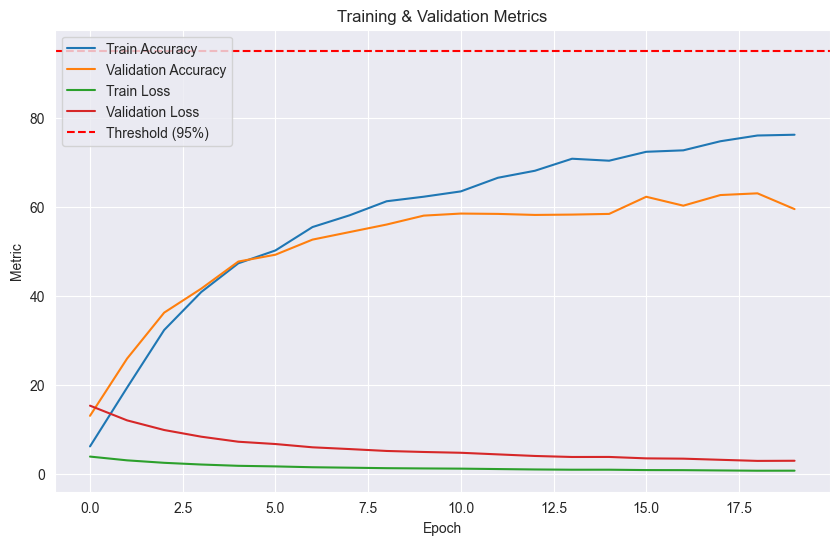

In [23]:
train_loss, val_loss, train_acc, val_acc = train(model_v3, optimizer=optimizer_v3, num_epochs=20)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

In [24]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes=75):
        super(CNN_v4, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        #batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)

        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        #add dropout
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.conv_layer1(x)))
        x = self.max_pool(F.relu(self.conv_layer2(x)))
        x = self.max_pool(F.relu(self.conv_layer3(x)))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv_layer1(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn2(self.conv_layer2(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn3(self.conv_layer3(x)))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x))) 
        x = self.fc2(x) 
        
        return x

In [25]:
model_v4 = CNN_v4(75).to(device)
optimizer_v4 = optim.Adam(model_v4.parameters(), lr=0.001)

100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


Epoch (1/20) train accuracy: 1.673398730525101, val accuracy: 2.076923076923077, train loss: 4.464955923033924, val loss: 17.434589794703893


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch (2/20) train accuracy: 2.3466051163685324, val accuracy: 2.3076923076923075, train loss: 4.1634997885401654, val loss: 16.257475364775885


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Epoch (3/20) train accuracy: 2.481246393537219, val accuracy: 2.3076923076923075, train loss: 4.096146801622902, val loss: 15.994477987289429


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch (4/20) train accuracy: 2.2504327755337563, val accuracy: 3.076923076923077, train loss: 4.0696365193622865, val loss: 15.890961647033691


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Epoch (5/20) train accuracy: 5.654933641084824, val accuracy: 7.153846153846154, train loss: 3.752145889328747, val loss: 14.65123632975987


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch (6/20) train accuracy: 11.482977495672245, val accuracy: 11.76923076923077, train loss: 3.282861029229513, val loss: 12.81879068556286


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Epoch (7/20) train accuracy: 15.329871129063282, val accuracy: 19.153846153846153, train loss: 3.0807185289336414, val loss: 12.029472351074219


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch (8/20) train accuracy: 20.830929024812463, val accuracy: 22.923076923076923, train loss: 2.780051833245812, val loss: 10.855440491721744


100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Epoch (9/20) train accuracy: 25.658780534718215, val accuracy: 26.53846153846154, train loss: 2.5546760588157467, val loss: 9.975401753471012


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch (10/20) train accuracy: 29.8711290632814, val accuracy: 33.76923076923077, train loss: 2.412345109916315, val loss: 9.419633286339897


100%|██████████| 21/21 [00:22<00:00,  1.07s/it]


Epoch (11/20) train accuracy: 32.121561838815154, val accuracy: 32.69230769230769, train loss: 2.2886911528866465, val loss: 8.936794025557381


100%|██████████| 21/21 [00:20<00:00,  1.02it/s]


Epoch (12/20) train accuracy: 36.0069244085401, val accuracy: 32.76923076923077, train loss: 2.2004562470971085, val loss: 8.592257726760138


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Epoch (13/20) train accuracy: 37.58415079823043, val accuracy: 39.53846153846154, train loss: 2.1098011019753247, val loss: 8.238270969617934


100%|██████████| 21/21 [00:20<00:00,  1.02it/s]


Epoch (14/20) train accuracy: 38.81515676091556, val accuracy: 37.76923076923077, train loss: 2.0759917802926973, val loss: 8.10625361828577


100%|██████████| 21/21 [00:31<00:00,  1.50s/it]


Epoch (15/20) train accuracy: 40.29621080977111, val accuracy: 37.53846153846154, train loss: 2.022500631285877, val loss: 7.897383417401995


100%|██████████| 21/21 [00:31<00:00,  1.50s/it]


Epoch (16/20) train accuracy: 41.48874783612233, val accuracy: 39.69230769230769, train loss: 1.9759321343608018, val loss: 7.7155445246469405


100%|██████████| 21/21 [00:31<00:00,  1.50s/it]


Epoch (17/20) train accuracy: 43.56607039815349, val accuracy: 37.30769230769231, train loss: 1.8942248734032237, val loss: 7.396497124717349


100%|██████████| 21/21 [00:31<00:00,  1.52s/it]


Epoch (18/20) train accuracy: 44.02769763416042, val accuracy: 42.0, train loss: 1.8935851004065536, val loss: 7.393998963492257


100%|██████████| 21/21 [00:33<00:00,  1.60s/it]


Epoch (19/20) train accuracy: 45.508751683015966, val accuracy: 44.0, train loss: 1.8075248119307727, val loss: 7.057954027539208


100%|██████████| 21/21 [00:32<00:00,  1.55s/it]


Epoch (20/20) train accuracy: 46.89363339103674, val accuracy: 41.53846153846154, train loss: 1.7624454905347127, val loss: 6.881930010659354


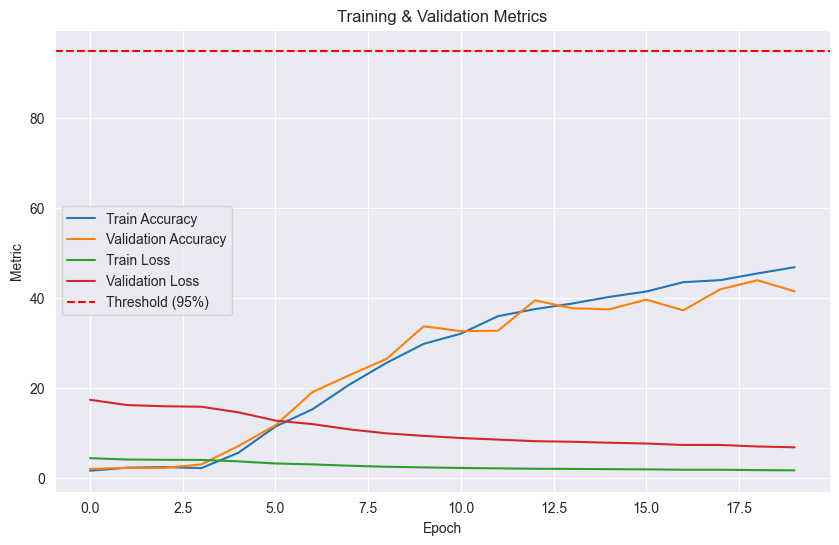

In [26]:
train_loss, val_loss, train_acc, val_acc = train(model_v4,optimizer=optimizer_v4,  num_epochs=20)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)